<a href="https://colab.research.google.com/github/iracheta827/InteligenciaArtificial/blob/main/IA_Eq5/PIA_IA_3raRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Kevin Woge Rivera 1834672
###Benito Briones Bautista 1838682
###Jose Emanuel Martinez Rodriguez 1851368
###Gregorio Missael Iracheta Arias 1851846

In [ ]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np


In [ ]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = sparse_categorical_crossentropy
no_classes = 100
no_epochs = 50
optimizer = RMSprop(learning_rate=0.0001)
validation_split = 0.2
verbosity = 1
channels = 3

In [ ]:
# Load CIFAR-10 data
(X_train, y_train), (X, y_test) = cifar100.load_data("coarse")

169017344/169001437 [==============================] - 2s 0us/step


[4]
[[[250 250 248]
  [248 249 243]
  [247 248 239]
  ...
  [250 250 246]
  [250 250 246]
  [249 250 246]]

 [[250 251 245]
  [248 249 238]
  [247 247 234]
  ...
  [251 251 242]
  [251 252 243]
  [250 251 243]]

 [[251 251 244]
  [250 248 237]
  [250 245 233]
  ...
  [250 249 238]
  [250 249 240]
  [250 249 242]]

 ...

 [[221 213 191]
  [221 206 176]
  [225 207 181]
  ...
  [199 176 134]
  [207 193 165]
  [233 229 226]]

 [[225 223 204]
  [227 219 196]
  [229 216 200]
  ...
  [204 185 151]
  [212 201 180]
  [234 232 228]]

 [[233 233 226]
  [234 232 224]
  [235 230 225]
  ...
  [219 209 194]
  [223 216 207]
  [232 230 228]]]


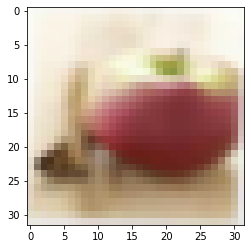

In [ ]:
plt.imshow(X_train[2])
print(y_train[2])
print(X_train[2])

In [ ]:
# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(X_train, y_train):
    X_train_data, X_val_data = X_train[train_index], X_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Number of training samples:  40000
Number of validation samples:  10000


In [ ]:
import tensorflow as tf
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(img_height, img_width), channels=channels, n_classes=no_classes, shuffle=True, augment=False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples & batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to #obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

In [ ]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True) 
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

In [ ]:
# Create the model
model = Sequential()
model.add(Conv2D(128 , kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [ ]:
#Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Epoch 1/50
800/800 [==============================] - 46s 20ms/step - loss: 2.8039 - accuracy: 0.1894 - val_loss: 2.4473 - val_accuracy: 0.2596
Epoch 2/50
800/800 [==============================] - 13s 16ms/step - loss: 2.3453 - accuracy: 0.2853 - val_loss: 2.2703 - val_accuracy: 0.3015
Epoch 3/50
800/800 [==============================] - 11s 14ms/step - loss: 2.1932 - accuracy: 0.3282 - val_loss: 2.1529 - val_accuracy: 0.3385
Epoch 4/50
800/800 [==============================] - 12s 15ms/step - loss: 2.0762 - accuracy: 0.3615 - val_loss: 2.1196 - val_accuracy: 0.3514
Epoch 5/50
800/800 [==============================] - 12s 15ms/step - loss: 1.9849 - accuracy: 0.3881 - val_loss: 2.0447 - val_accuracy: 0.3788
Epoch 6/50
800/800 [==============================] - 12s 15ms/step - loss: 1.9025 - accuracy: 0.4142 - val_loss: 2.0260 - val_accuracy: 0.3797
Epoch 7/50
800/800 [==============================] - 12s 14ms/step - loss: 1.8282 - accuracy: 0.4326 - val_loss: 1.9443 - val_accuracy:

Test loss: 3.3940954208374023 / Test accuracy: 0.44179999828338623


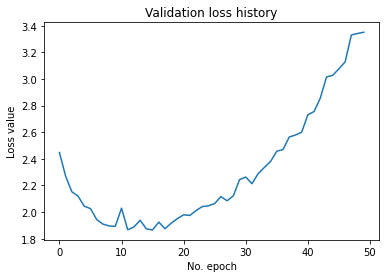

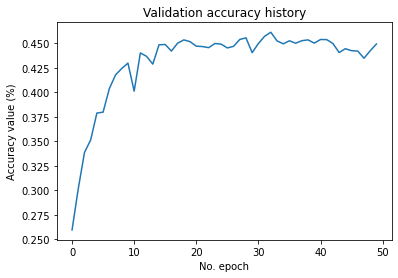

In [ ]:
# Generate generalization metrics
score = model.evaluate(X, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

<Figure size 432x288 with 0 Axes>

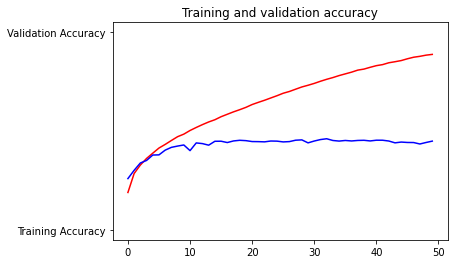

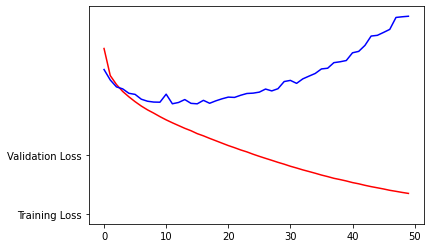

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
 
epochs=range(len(acc)) # Get number of epochs
 
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()
 
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()